### Goal:
Generate Lazar predictions for the blood-brain barrier penetration.

#### Load libraries

In [ ]:
from pip._internal import main as pip
#%pip install pandas
try:
    import requests
except ImportError:
    pip(['install', 'request'])
    import requests

try:
    import pandas as pd
except ImportError:
    pip(['install', 'pandas'])
    import pandas as pd
    
try:
    import urllib
except ImportError:
    pip(['install', 'urllib'])
    import urllib
    
try:
    import json
except ImportError:
    pip(['install', 'json'])
    import json
    
try:
    from io import StringIO
except ImportError:
    pip(['install', 'io'])
    from io import StringIO
    
try:
    import pprint
except ImportError:
    pip(['install', 'pprint'])
    import pprint
    
try:
    import numpy as np
except ImportError:
    pip(['install', 'numpy'])
    import numpy as np
#%pip install sklearn    
try:
    import sklearn
    from sklearn import metrics
except ImportError:
    pip(['install', 'sklearn'])
    import sklearn
    from sklearn import metrics
#%pip install matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    pip(['install', 'matplotlib'])
    import matplotlib.pyplot as plt

#### Authorize the user to get subjectid

In [15]:
base = 'https://lazar.prod.openrisknet.org'

url = '/'.join([base,'authenticate','login'])
headers = {'accept': 'application/json', 'Content-Type': 'application/x-www-form-urlencoded'}
payload = {'username':'name', 'password': 'pw'}

r = requests.post(url, headers=headers, data=payload)
if r.status_code == 200:
    res = r.json()
    subjectid = res['subjectid']
else:
    print(r.json())

#### Get list of endpoints available through Lazar web service

In [17]:
#base = 'https://lazar.prod.openrisknet.org'

url = '/'.join([base, 'endpoint'])
headers = {'accept': 'application/json', 'subjectid': subjectid}

r = requests.get(url, headers=headers)

if r.status_code == 200:
    endpoints = json.loads(r.content.decode('utf-8'))
else:
    print('Error accessing web service')
pprint.pprint(endpoints)

['Blood Brain Barrier Penetration',
 'Carcinogenicity',
 'Mutagenicity',
 'Lowest observed adverse effect level (LOAEL)',
 'Acute toxicity',
 'Maximum Recommended Daily Dose']


#### Select the Blood Brain Barrier Penetration endpoint and get the list of species with this endpoint

In [18]:
# select the relevant endpoint
endpoint = endpoints[0]

# get URL to access the model
url = '/'.join([base, 'endpoint', endpoint])
headers = {'accept': 'application/json', 'subjectid': subjectid}

r = requests.get(url, headers=headers)

if r.status_code == 200:
    # list of species for a given endpoint
    speciesList = json.loads(r.content.decode('utf-8'))
    pprint.pprint(speciesList)
else:
    print('Error accessing web service')

[{'Human': 'https://lazar.prod.openrisknet.org/model/5ae2dd885f1c2d01323270ee'}]


#### Select the relevant species (Human) and get the model information

In [19]:
# select species
species = 'Human'

# url of the model for the selected species
modelUrl = speciesList[0][species]

r = requests.get(modelUrl, headers=headers)

if r.status_code == 200:
    modelInfo = json.loads(r.content.decode('utf-8'))

    pprint.pprint(modelInfo)
else:
    print('Error accessing web service')

{'_id': {'$oid': '5ae2dd885f1c2d01323270ee'},
 'created_at': '2018-04-27T08:21:28.530+00:00',
 'endpoint': 'Blood Brain Barrier Penetration',
 'model_id': {'$oid': '5ae2dd695f1c2d0132326ff7'},
 'qmrf': {'group': 'QMRF 5. Toxicokinetics',
          'name': 'QMRF 5.4. Toxicokinetics.Blood-brain barrier penetration'},
 'repeated_crossvalidation_id': {'$oid': '5ae2dd885f1c2d01323270ed'},
 'source': 'http://cheminformatics.org/datasets/',
 'species': 'Human',
 'training_dataset': '5ae2dd675f1c2d0132326e63',
 'unit': None,
 'updated_at': '2018-04-27T08:21:28.530+00:00'}


#### Access the training dataset

In [21]:
# training ID
trainingId = modelInfo['training_dataset']

# access the training dataset
headers = {'accept': 'text/csv', 'subjectid': subjectid}
url = '/'.join([base, 'dataset', trainingId])

r = requests.get(url, headers=headers)

if r.status_code == 200:
    dfTrain = pd.read_csv(StringIO(r.text))
else:
    print('Error accessing web service')
    
dfTrain.head()

,SMILES,Blood-Brain-Barrier Penetration
0,OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)...,non-penetrating
1,NCCc1nc2n(c1)cccc2,non-penetrating
2,NCCc1nc2n(c1)cccc2,non-penetrating
3,CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,penetrating
4,Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CC...,penetrating


#### Store the set of compounds

In [22]:
dfTrain.to_csv('compounds.csv', index=False)

#### Loop over compounds of the training set and make predictions

In [23]:
dfLazar = dfTrain.copy()

for index, row in dfTrain.iterrows():
    mol = row['SMILES']
    body = {'identifier': mol}

    headers = {'accept': 'text/csv', 'subjectid': subjectid}

    result = requests.post(modelUrl, headers=headers, data=body)
    result = json.loads(result.text)
    
    try:
        dfLazar.at[index, 'Predicted'] = result['prediction']['value']
    except KeyError:
        dfLazar.at[index, 'Predicted'] = np.nan
        
    try:
        dfLazar.at[index, 'Probability_P'] = result['prediction']['probabilities']['penetrating']
    except KeyError:
        dfLazar.at[index, 'Predicted'] = np.nan
        
    try:
        dfLazar.at[index, 'Probability_N'] = result['prediction']['probabilities']['non-penetrating']
    except KeyError:
        dfLazar.at[index, 'Predicted'] = np.nan

dfLazar.head()

,SMILES,Blood-Brain-Barrier Penetration,Predicted,Probability_P,Probability_N
0,OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)...,non-penetrating,penetrating,0.458281,0.398862
1,NCCc1nc2n(c1)cccc2,non-penetrating,penetrating,0.107072,0.050823
2,NCCc1nc2n(c1)cccc2,non-penetrating,penetrating,0.107072,0.050823
3,CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,penetrating,penetrating,0.317589,0.099078
4,Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CC...,penetrating,penetrating,0.691857,0.089393


#### Store Lazar predictions

In [87]:
dfLazar = dfLazar.rename(columns={'Blood-Brain-Barrier Penetration': 'True'})
dfLazar.to_csv('predictions_Lazar.csv', index=False)

#### Evalute model performance:
- confusion matrix
- ROC, AUC

In [88]:
# confusion matrix
conf = pd.crosstab(dfLazar['True'], dfLazar['Predicted'])
conf

Predicted,non-penetrating,penetrating
True,,
non-penetrating,60,69
penetrating,28,222


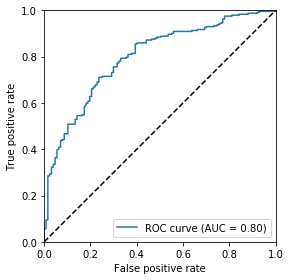

In [128]:
# ROC plot
df = dfLazar.copy()

df = df.dropna(axis=0, how='any').drop_duplicates()

df['Probability_diff'] = (df['Probability_P'] - df['Probability_N']) # / 2. + 0.5
df['True'] = df['True'].replace({'penetrating': 1, 'non-penetrating': 0})

# compute ROC
fpr, tpr, thresholds = metrics.roc_curve(df['True'], df['Probability_diff'], pos_label=1)

# compute AUC
auc = metrics.auc(fpr, tpr)

# prepare the plot
fig, ax = plt.subplots(1, 1)

ax.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
ax.plot([0,1], [0,1], label='', color='black', linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.set_aspect('equal')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

fig.tight_layout()

plt.show()